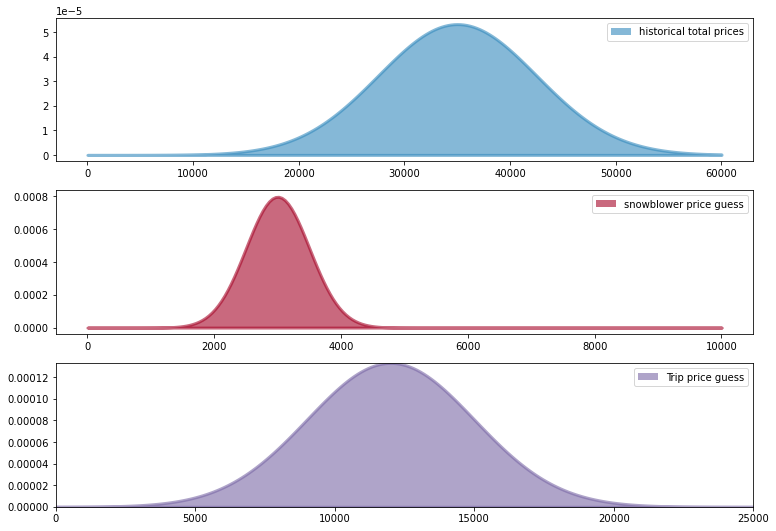

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x , 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x , 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x , 0, norm_pdf(x, 12000, 3000), 
                 color = "#7A68A6", lw = 3, alpha = 0.6,
                 label = "Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [2]:
import pymc3 as pm

data_mu = [3e3, 12e3]

data_std =  [5e2, 3e3] 

mu_prior = 35e3
std_prior =  75e2
with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    

    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace["true_price"]

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [second_prize]
>Metropolis: [first_prize]
>Metropolis: [true_price]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 25 seconds.
The number of effective samples is smaller than 10% for some parameters.


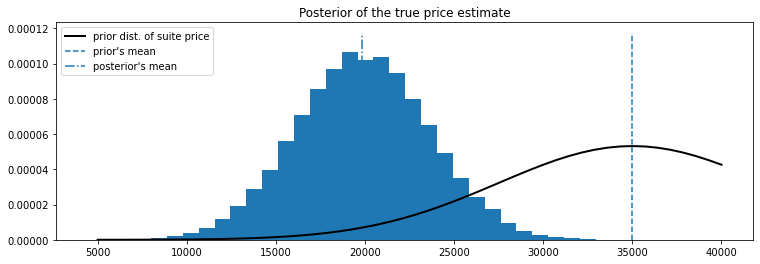

In [4]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, 
         label = "prior dist. of suite price")

_hist = plt.hist(price_trace, bins = 35, density= True, histtype= "stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label = "prior's mean",
           linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), \
           label = "posterior's mean", linestyles="-.")
plt.legend(loc = "upper left");

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprec

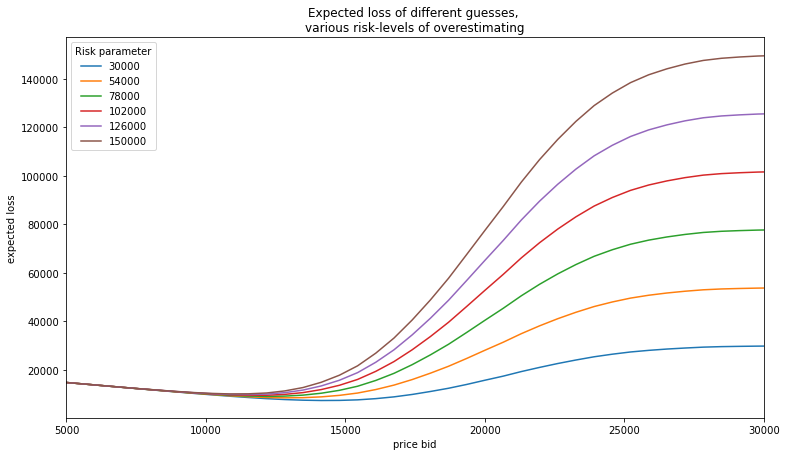

In [5]:
figsize(12.5, 7)
#numpy friendly showdown_loss


def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()
        
for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprec

minimum at risk 30000: 13968.88
minimum at risk 54000: 12714.79
minimum at risk 78000: 12153.52


/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprec

minimum at risk 102000: 11768.16
minimum at risk 126000: 11468.73
minimum at risk 150000: 10899.47


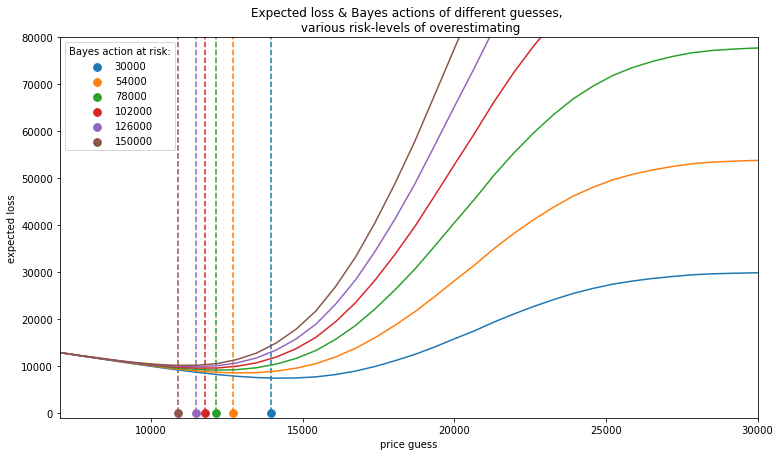

In [6]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))
                                    
plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

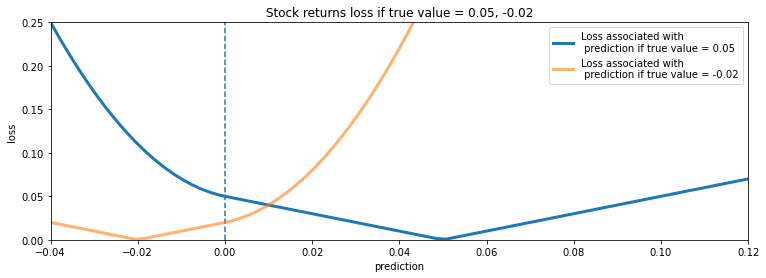

In [7]:
figsize(12.5, 4)


def stock_loss(true_return, yhat, alpha = 100.):
    if true_return * yhat < 0:
        #opposite signs, not good
        return alpha*yhat**2 - np.sign(true_return)*yhat \
                        + abs(true_return) 
    else:
        return abs(true_return - yhat)
    
    
true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], \
        label = "Loss associated with\n prediction if true value = 0.05", lw =3) 
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = 0.6, \
        label = "Loss associated with\n prediction if true value = -0.02", lw =3) 
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

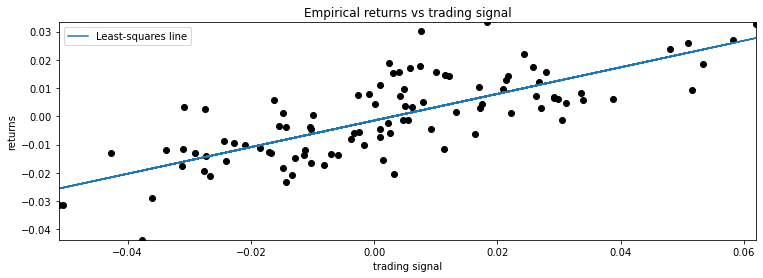

In [8]:
## Code to create artificial data
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N) 

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label = "Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

In [9]:
import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]  

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [std]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 55 seconds.
The number of effective samples is smaller than 10% for some parameters.


/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,

AttributeError: 'Line2D' object has no property 'kde_plot'

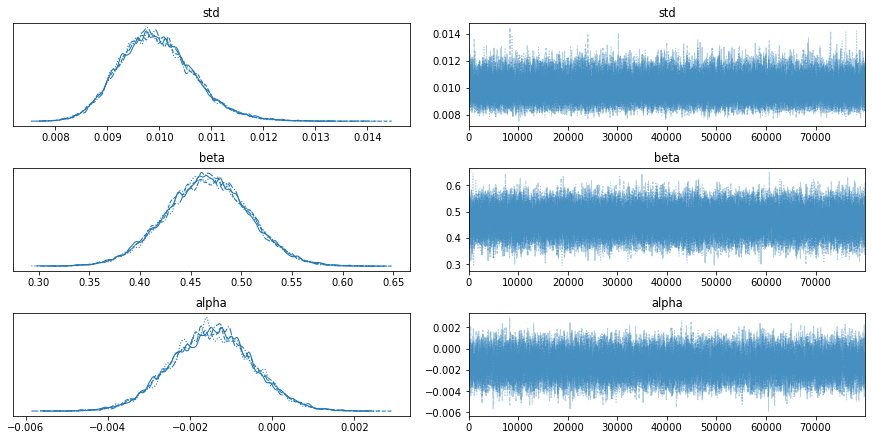

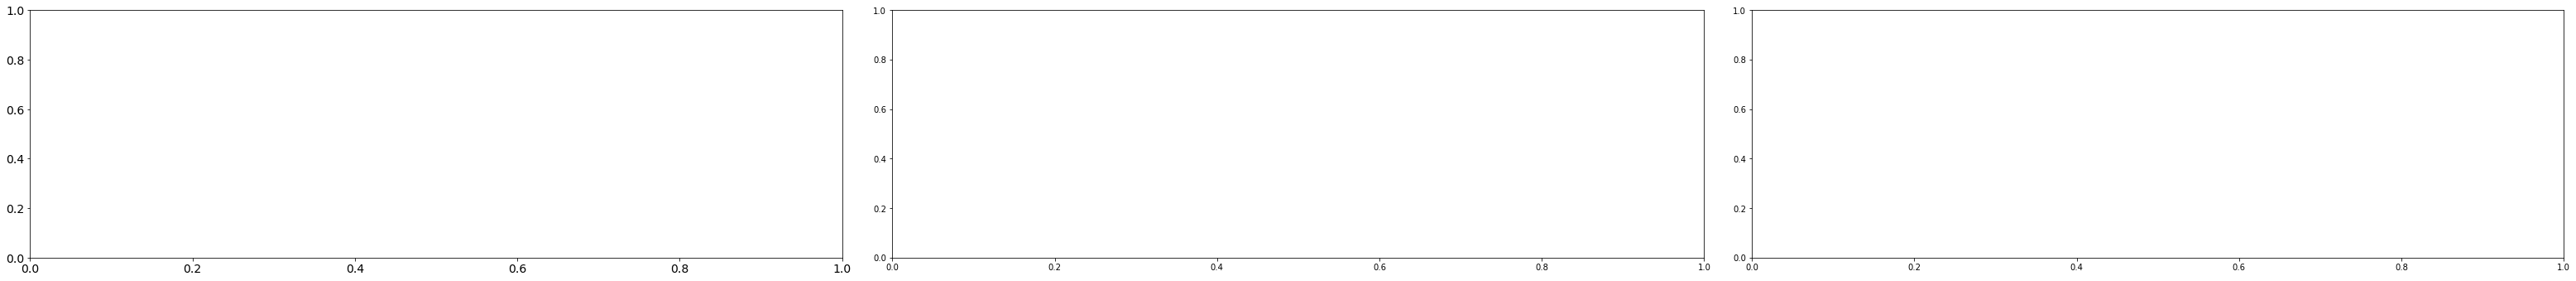

In [16]:

pm.plots.traceplot(burned_trace, var_names=["std", "beta", "alpha"])
#pm.plot_posterior(burned_trace, var_names=["std", "beta", "alpha"], kde_plot=True);

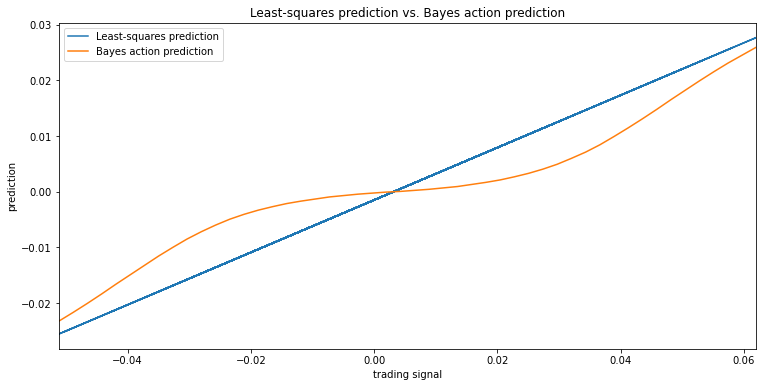

In [17]:
figsize(12.5, 6)
from scipy.optimize import fmin


def stock_loss(price, pred, coef = 500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals =  np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = fmin(tomin, 0, disp = False)
        
        
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label ="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left");

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i,:]
        x,y = _g[0], _g[1]
        d = np.sqrt( _g[2]**2 + _g[3]**2 )
        a = 1.0/ ( 1 - d )
        b = 1.0/( 1 + d)
        theta = np.degrees( np.arctan2( _g[3], _g[2])*0.5 )
        
        ax.add_patch( Ellipse(xy=(x, y), width=size_multiplier*a, height=size_multiplier*b, angle=theta) )
    ax.autoscale_view(tight=True)
    
    return fig

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]


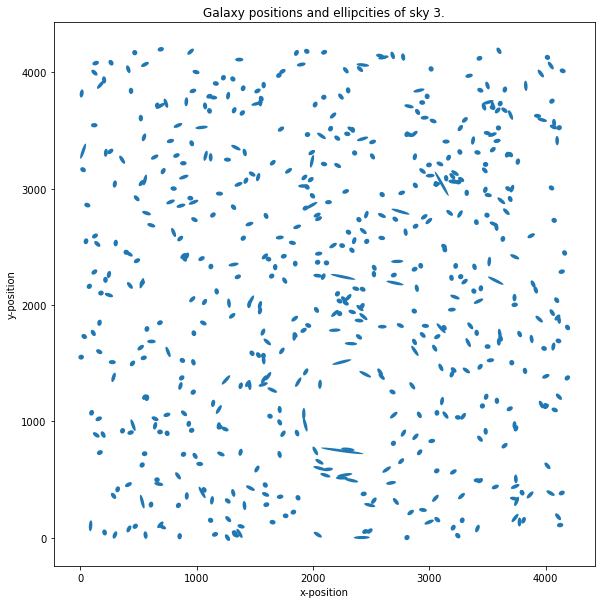

In [24]:
#from draw_sky2 import draw_sky

n_sky = 3 #choose a file/sky to examine.
data = np.genfromtxt("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/data/Train_Skies/Train_Skies/Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");